In [1]:
from generate_data import Data
from evaluate import *
from models import *

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
%autosave 120

Autosaving every 120 seconds


# Get the synthetic dataset

In [4]:
%%time
data = Data(layer_size=16, interop_distances=[0,1,2], permutation_intervals=2)

C:\Users\Luna Santos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(


CPU times: total: 3.47 s
Wall time: 4.3 s


In [5]:
%%time
train, val, test = data.get_splits(['1st_interval', 'omit_distances'], [[1]])

train_unshuffled = train.copy()
np.random.shuffle(train)

x_train, y_train = data.get_x_y(train)
x_val, y_val = data.get_x_y(val)
x_test, y_test = data.get_x_y(test)

train_original = data.reverse_encoding(data.get_x_y(train_unshuffled)[0])
val_original = data.reverse_encoding(x_val)
test_original = data.reverse_encoding(x_test)

Number of samples: 1801 train | 406 val | 1624 test
CPU times: total: 1min 1s
Wall time: 1min 5s


#### Peek at unshuffled train data

In [6]:
train_original[:20]

[[',..._.._,.___._.', 'w,,_,.,_,__.._.,', 'cr__,._,._,._,__', False],
 [',___._.,_.,,..,_', 'w_.,.,._,_._..,,', ',cr,__,,._._.,,_', False],
 [',_..,__......___', 'w__.____,_,..___', '.,cr_.__._.,..._', False],
 ['_.,,.,....,__._,', 'w,.,.,.___,_,_,_', '.._cr_.___.,,,.,', False],
 [',.._.._,_...,.,_', 'w.__,,_,,_,__..,', '..,_cr_.,.,_.___', False],
 [',,.._.....,,,,,_', 'w_,.._.,...,_.,_', '...__cr..,__,_..', False],
 ['__....,,,._..,,.', 'w.._.,.,__.,.__.', '._..,_cr.,_,__.,', False],
 [',,,__..__.____,.', '_w__,_._,,.__,,.', 'cr...__,..,,__,.', False],
 ['..,._,.__.,__,,_', ',w,_,..__,_,_,..', '_cr,._,__.._,___', False],
 [',.,.,,__,,._.,__', ',w,,_,.__..__,,,', '_,cr_,.,._____.,', False],
 [',__._,_.___._.,_', '.w..._,__.__.___', ',,,cr,,__..._,,.', False],
 ['__,,._,..,,,._,_', '_w.___,.,,,.,,._', '__..cr__.,.,,._.', False],
 ['_,,,,,._.,..,___', '.w,_.,_,__,.,__,', '.,..,cr.__...,..', False],
 [',,_._,._,.,....,', '.w.,,,_____.,.._', '.,_,_,cr_._,,,..', False],
 ['.,....__,___,,_,'

In [7]:
pos_train_ratio = get_stats_and_ratio(train_original)

Number of samples by case:
F3 dr:    F2-wu 85 | F2-uw 85 | F2-w 98 | F2-noop 98 | 
F3 cr:    F2-wu 85 | F2-uw 85 | F2-w 98 | F2-noop 98 | 
F3 r:    F2-wu 98 | F2-uw 98 | F2-w 162 | F2-noop 169 | 
F3 noop:    F2-wu 98 | F2-uw 98 | F2-w 169 | F2-noop 177 | 

Positive samples count: 808
Total samples count: 1801
Positive class ratio: 0.4486396446418656


#### Peek at test data

In [8]:
test_original[:15]

[['_,..,_.,,_..,.,.', '.._,.,..,_,_,__.', '_,____,__,_._,_.', False],
 ['._,_._.._,_,.._.', '._._,,_,.,w.,,,.', '__,,..___.,d_r._', True],
 ['._.,,__,___,,,..', '__.,,._,w.u..._,', ',,.__..,,,c_r.,,', False],
 ['..__._...,._,,_.', ',______.,,.,,.__', '..__,.c,r__.,__,', False],
 ['__,.._.,.,,,,._,', ',.._,_.,_.,._u.w', '_.__..,c_r,_._._', False],
 ['._.,____,,..__._', '.._._.,___,.,,,,', '__..___..._,,_..', False],
 ['.,,_,,,..___.,_.', ',u,w_..__.,_,._.', ',_d_r.,_,.,,.._.', True],
 ['.,,._.,__._.___,', '.,,,..u,w.._._,.', '.__._._,,.__,,,.', False],
 ['._,..,,_,._..___', '.,,__,,w_,.__,_,', ',____.,..__..__.', False],
 ['_,.._.,.__,,_,,.', ',,,..,,_,__,.___', '.,__,__,_,...,__', False],
 ['._,___,,._,.,,..', ',,_.,__,,.._.___', ',c.r.._,_.,,.__,', False],
 ['_.__,.,__..,,,_.', ',.._,___._,__.,_', '_.____.._.,.c.r,', False],
 ['_._,___.._..,._,', ',,..,,___w_u,,._', ',,_,,.,.,.r,.,_.', True],
 ['.,_.,_.,,.,._,.,', '_,._.,,,,..,w,_,', ',.___..,_d,r._,.', True],
 ['__,__._,,.__.,_,', '_

In [9]:
pos_test_ratio = get_stats_and_ratio(test_original)

Number of samples by case:
F3 dr:    F2-wu 84 | F2-uw 69 | F2-w 86 | F2-noop 87 | 
F3 cr:    F2-wu 77 | F2-uw 77 | F2-w 83 | F2-noop 90 | 
F3 r:    F2-wu 79 | F2-uw 91 | F2-w 140 | F2-noop 157 | 
F3 noop:    F2-wu 88 | F2-uw 88 | F2-w 158 | F2-noop 170 | 

Positive samples count: 709
Total samples count: 1624
Positive class ratio: 0.43657635467980294


#### Peek at val data

In [10]:
val_original[:15]

[['.,,._,__..,.,.,_', ',,_..,w,u_.__._,', ',.,,_...,..__,_,', False],
 ['_,..,.._,.,,,_.,', ',__,_,_..,.._,,.', '.,.,,,.,_,_,,.._', False],
 ['_,._,_.,..,_.___', '...,,,,__..u,w..', ',_,._,_..,,_,.,_', False],
 ['..__,,...._.__,.', '__,.._,_,u.w,_..', '.,____._,.._d.r.', True],
 [',_.__.__,._,,_..', ',w_u,,.,.,,,,_.,', '_,_.,_,,,_,_,_..', False],
 ['.,,,____,,,..__.', '_,._._w..._...._', ',,..d,r,_..,_,_.', True],
 ['_._,.._....,.,__', '.._.,,,.,,._w._,', '_,__,.,r__,..,..', True],
 ['_..._.__..___,._', ',_,.,...,,.w,u_.', ',.._,_,_,.__r,_,', True],
 ['..,_,,,,,,.,_._.', '_....,,,.,.__w,_', ',,_,.,,____.r_,_', True],
 [',__,._.,._,,_.__', '____,._,.._.,,w_', '.._..,_,__r,,.__', True],
 [',_,.,.,_..,..,,,', ',,,,.._.,,..,_,_', ',.__.,_._,.,_,.,', False],
 [',_,.,_,,_.__....', ',,.,,,.,,,_,,_.,', ',__.,.,,_.,_._._', False],
 ['.,,.....,,_,_._,', '___w_,,,..__,_.,', 'c_r.._____,.,..,', False],
 ['.,..,.,_,,,__,.,', ',_,.__.,_.,,,,__', ',.,,..___.r.___,', True],
 [',,,_.__._,_,_.,,', '.u,w

In [11]:
pos_val_ratio = get_stats_and_ratio(val_original)

Number of samples by case:
F3 dr:    F2-wu 14 | F2-uw 29 | F2-w 19 | F2-noop 25 | 
F3 cr:    F2-wu 21 | F2-uw 21 | F2-w 22 | F2-noop 22 | 
F3 r:    F2-wu 26 | F2-uw 14 | F2-w 37 | F2-noop 35 | 
F3 noop:    F2-wu 24 | F2-uw 24 | F2-w 34 | F2-noop 39 | 

Positive samples count: 185
Total samples count: 406
Positive class ratio: 0.45566502463054187


#### Send label arrays to device

In [12]:
y_train = torch.from_numpy(y_train.astype(float)).float().to(device)
y_val = torch.from_numpy(y_val.astype(float)).float().to(device)
y_test = torch.from_numpy(y_test.astype(float)).float().to(device)

#### Get data in normal format (same as CNN format)

In [13]:
x_train_normal = data.to_conv_format(x_train)
x_val_normal = data.to_conv_format(x_val)
x_test_normal = data.to_conv_format(x_test)
for i in range(len(x_train_normal)):
    x_train_normal[i] = x_train_normal[i].to(device)
    x_val_normal[i] = x_val_normal[i].to(device)
    x_test_normal[i] = x_test_normal[i].to(device)

In [14]:
x_train_normal[0].shape

torch.Size([1801, 128])

#### Get data in convolutional format, send to device

In [15]:
x_train_cnn = data.to_conv_format(x_train, padding_left_size=2, padding_right_size=2)
x_val_cnn = data.to_conv_format(x_val, padding_left_size=2, padding_right_size=2)
x_test_cnn = data.to_conv_format(x_test, padding_left_size=2, padding_right_size=2)
for i in range(len(x_train_cnn)):
    x_train_cnn[i] = x_train_cnn[i].to(device)
    x_val_cnn[i] = x_val_cnn[i].to(device)
    x_test_cnn[i] = x_test_cnn[i].to(device)

In [16]:
x_train_cnn[0].shape

torch.Size([1801, 160])

#### Get data in LSTM format, send to device

In [17]:
x_train_lstm = data.to_lstm_format(x_train, padding_left_size=2, padding_right_size=0)
x_val_lstm = data.to_lstm_format(x_val, padding_left_size=0, padding_right_size=2)
x_test_lstm = data.to_lstm_format(x_test, padding_left_size=0, padding_right_size=2)
for i in range(len(x_train_lstm)):
    x_train_lstm[i] = x_train_lstm[i].to(device)
    x_val_lstm[i] = x_val_lstm[i].to(device)
    x_test_lstm[i] = x_test_lstm[i].to(device)

In [18]:
x_train_lstm[0].shape

torch.Size([1801, 18, 8])

### Define training parameters

In [19]:
num_experiments = 20
epochs = 200
early_stopping_limit = 100

experiment_name = "f2_f4_easy_redo"

### Define training procedure for each model

In [20]:
def train_models(constructor, x_train, x_val, x_test, weight_decay, *argv):
    accuracies = [] #lista con la precisión de cada modelo en el cjto de prueba
    precisions = []
    recalls = []
    f1_scores = []
    wrong_preds = []#lista con las predicciones incorrectas del modelo en el cjto de prueba
    best_accuracy = 0
    
    #listas de listas de cada modelo durante el entrenamiento y prueba
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for i in range(num_experiments):
        model = constructor(*argv)
        model.to(device)

        criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([(1-pos_train_ratio)/pos_train_ratio]).to(device))
        optimizer = optim.Adam(model.parameters(), weight_decay=weight_decay)

        train_losses.append([])
        val_losses.append([])
        train_accs.append([])
        val_accs.append([])
        
        best_acc = 0

        early_stopping_cnt = 0

        for epoch in range(1, epochs + 1):
            train_loss, train_acc = train_epoch(model, x_train, y_train, criterion, optimizer, epoch, 10, verbose=False)
            val_loss, val_acc = eval_epoch(model, x_val, y_val, criterion, 'Validation', verbose=False)

            
            train_losses[-1].append(train_loss)
            val_losses[-1].append(val_loss)
            train_accs[-1].append(train_acc)
            val_accs[-1].append(val_acc)
            
            model_name = constructor.__name__[:constructor.__name__.find('_')]
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), f'./temp/{model_name}_model_TEMP_' + experiment_name)    
                early_stopping_cnt = 0
            else:
                early_stopping_cnt += 1

            if early_stopping_cnt >= early_stopping_limit:
                break

        model.load_state_dict(torch.load(f'./temp/{model_name}_model_TEMP_' + experiment_name))

        accuracies.append(get_accuracy_by_cases(model, x_test, y_test, test_original)) #Se evalúa el modelo en el conjunto de prueba 
        precisions.append(get_precision(model, x_test, y_test, test_original))
        recalls.append(get_recall(model, x_test, y_test, test_original))
        f1_scores.append(get_f1(precisions[-1], recalls[-1]))        
        
        wrong_preds.append(get_wrong_predictions(model, x_test, y_test, test_original))

        if accuracies[-1]['Overall'] > best_accuracy:
            torch.save(model.state_dict(), f'./bestmodels/best_{model_name}_model_' + experiment_name)    
            best_accuracy = accuracies[-1]['Overall']

        print(i + 1, "/", num_experiments, "models trained | Current model best validation accuracy:", best_accuracy)

    return accuracies, precisions, recalls, f1_scores,  wrong_preds, [train_losses, val_losses, train_accs, val_accs]

# Train models

In [21]:
%%time
cnn_accuracies, cnn_precisions, cnn_recall, cnn_f1_scores, cnn_wrong_preds, cnn_epoch_stats = train_models(CNN_Model, x_train_cnn, x_val_cnn, x_test_cnn, 0.005, data, 32, 64, 4, -1, 'keras')


1 / 20 models trained | Current model best validation accuracy: 0.9482758620689655
2 / 20 models trained | Current model best validation accuracy: 0.9482758620689655
3 / 20 models trained | Current model best validation accuracy: 0.9482758620689655
4 / 20 models trained | Current model best validation accuracy: 0.9532019704433498
5 / 20 models trained | Current model best validation accuracy: 0.9532019704433498
6 / 20 models trained | Current model best validation accuracy: 0.9532019704433498
7 / 20 models trained | Current model best validation accuracy: 0.9532019704433498
8 / 20 models trained | Current model best validation accuracy: 0.9532019704433498
9 / 20 models trained | Current model best validation accuracy: 0.9532019704433498
10 / 20 models trained | Current model best validation accuracy: 0.9532019704433498
11 / 20 models trained | Current model best validation accuracy: 0.9532019704433498
12 / 20 models trained | Current model best validation accuracy: 0.9532019704433498
1

In [22]:
%%time
lstm_accuracies, lstm_precisions, lstm_recall, lstm_f1_scores, lstm_wrong_preds, lstm_epoch_stats = train_models(LSTM_Model, x_train_lstm, x_val_lstm, x_test_lstm, 0.0001, data, 16, 32, 8, 'keras')

1 / 20 models trained | Current model best validation accuracy: 0.8903940886699507
2 / 20 models trained | Current model best validation accuracy: 0.9482758620689655
3 / 20 models trained | Current model best validation accuracy: 0.9482758620689655
4 / 20 models trained | Current model best validation accuracy: 0.9605911330049262
5 / 20 models trained | Current model best validation accuracy: 0.9605911330049262
6 / 20 models trained | Current model best validation accuracy: 0.9612068965517241
7 / 20 models trained | Current model best validation accuracy: 0.9778325123152709
8 / 20 models trained | Current model best validation accuracy: 0.9778325123152709
9 / 20 models trained | Current model best validation accuracy: 0.9778325123152709
10 / 20 models trained | Current model best validation accuracy: 0.9778325123152709
11 / 20 models trained | Current model best validation accuracy: 0.9778325123152709
12 / 20 models trained | Current model best validation accuracy: 0.9778325123152709
1

In [23]:
%%time
deepset_accuracies, deepset_precisions, deepset_recall, deepset_f1_scores,deepset_wrong_preds, deepset_epoch_stats = train_models(DEEPSET_Model, x_train_normal, x_val_normal, x_test_normal, 0.0001, data, 128, 32, 8, 'keras')

1 / 20 models trained | Current model best validation accuracy: 0.6939655172413793
2 / 20 models trained | Current model best validation accuracy: 0.6939655172413793
3 / 20 models trained | Current model best validation accuracy: 0.7068965517241379
4 / 20 models trained | Current model best validation accuracy: 0.7068965517241379
5 / 20 models trained | Current model best validation accuracy: 0.7075123152709359
6 / 20 models trained | Current model best validation accuracy: 0.7075123152709359
7 / 20 models trained | Current model best validation accuracy: 0.708128078817734
8 / 20 models trained | Current model best validation accuracy: 0.708128078817734
9 / 20 models trained | Current model best validation accuracy: 0.708128078817734
10 / 20 models trained | Current model best validation accuracy: 0.708128078817734
11 / 20 models trained | Current model best validation accuracy: 0.708128078817734
12 / 20 models trained | Current model best validation accuracy: 0.708128078817734
13 / 20

In [24]:
%%time
deepsetv2_accuracies, deepsetv2_precisions, deepsetv2_recall, deepsetv2_f1_scores, deepsetv2_wrong_preds, deepsetv2_epoch_stats = train_models(DEEPSETV2_Model, x_train_normal, x_val_normal, x_test_normal, 0.0001, data, 32, 8, 'keras')

1 / 20 models trained | Current model best validation accuracy: 0.43657635467980294
2 / 20 models trained | Current model best validation accuracy: 0.43657635467980294
3 / 20 models trained | Current model best validation accuracy: 0.43657635467980294
4 / 20 models trained | Current model best validation accuracy: 0.43657635467980294
5 / 20 models trained | Current model best validation accuracy: 0.43657635467980294
6 / 20 models trained | Current model best validation accuracy: 0.43657635467980294
7 / 20 models trained | Current model best validation accuracy: 0.43657635467980294
8 / 20 models trained | Current model best validation accuracy: 0.43657635467980294
9 / 20 models trained | Current model best validation accuracy: 0.43657635467980294
10 / 20 models trained | Current model best validation accuracy: 0.43657635467980294
11 / 20 models trained | Current model best validation accuracy: 0.43657635467980294
12 / 20 models trained | Current model best validation accuracy: 0.4365763

In [25]:
%%time
feedforward_accuracies, feedforward_precisions, feedforward_recall, feedforward_f1_scores, feedforward_wrong_preds, feedforward_epoch_stats = train_models(FEEDFORWARD_Model, x_train_normal, x_val_normal, x_test_normal, 0.0001, data, 128, 32, 8, 'keras')

1 / 20 models trained | Current model best validation accuracy: 0.7044334975369458
2 / 20 models trained | Current model best validation accuracy: 0.7044334975369458
3 / 20 models trained | Current model best validation accuracy: 0.7044334975369458
4 / 20 models trained | Current model best validation accuracy: 0.7044334975369458
5 / 20 models trained | Current model best validation accuracy: 0.7044334975369458
6 / 20 models trained | Current model best validation accuracy: 0.7118226600985221
7 / 20 models trained | Current model best validation accuracy: 0.7118226600985221
8 / 20 models trained | Current model best validation accuracy: 0.7118226600985221
9 / 20 models trained | Current model best validation accuracy: 0.7118226600985221
10 / 20 models trained | Current model best validation accuracy: 0.7118226600985221
11 / 20 models trained | Current model best validation accuracy: 0.7124384236453202
12 / 20 models trained | Current model best validation accuracy: 0.7124384236453202
1

# Evaluation

In [26]:
all_accuracies = [cnn_accuracies, lstm_accuracies, deepset_accuracies, deepsetv2_accuracies, feedforward_accuracies]
all_precisions = [cnn_precisions, lstm_precisions, deepset_precisions, deepsetv2_precisions, feedforward_precisions]
all_recalls = [cnn_recall, lstm_recall, deepset_recall, deepsetv2_recall, feedforward_recall]
all_f1_scores = [cnn_f1_scores, lstm_f1_scores, deepset_f1_scores, deepsetv2_f1_scores, feedforward_f1_scores]

model_names = ['CNN', 'LSTM', 'DeepSet(like in paper)', 'DeepSet(sum at start)', 'Feedforward']

In [27]:
get_summary_df(model_names, all_accuracies, all_precisions, all_recalls, all_f1_scores)

                   Modelo  Accuracy  Precision    Recall  F1-score
0                     CNN  0.953202   0.904215  0.998590  0.949062
1                    LSTM  1.000000   1.000000  1.000000  1.000000
2  DeepSet(like in paper)  0.716133   0.905229  0.390691  0.545813
3   DeepSet(sum at start)  0.436576   0.436576  1.000000  0.607801
4             Feedforward  0.719828   0.917763  0.393512  0.550839


## Accuracies per CNN model

In [28]:
get_stats_per_model(cnn_accuracies, ['CNN #' + str(i) for i in range(len(cnn_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
CNN #0,94.8%,100.0%,74.2%,100.0%,100.0%
CNN #1,94.8%,100.0%,74.2%,100.0%,100.0%
CNN #2,94.8%,100.0%,74.2%,100.0%,100.0%
CNN #3,95.3%,100.0%,76.7%,100.0%,100.0%
CNN #4,94.8%,100.0%,74.2%,100.0%,100.0%
CNN #5,94.8%,100.0%,74.2%,100.0%,100.0%
CNN #6,94.8%,100.0%,74.2%,100.0%,100.0%
CNN #7,94.8%,100.0%,74.2%,100.0%,100.0%
CNN #8,94.6%,100.0%,73.6%,100.0%,99.6%
CNN #9,94.7%,100.0%,73.6%,100.0%,100.0%


## Accuracies per LSTM model

In [29]:
get_stats_per_model(lstm_accuracies, ['LSTM #' + str(i) for i in range(len(lstm_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
LSTM #0,89.0%,100.0%,82.2%,100.0%,74.3%
LSTM #1,94.8%,100.0%,98.5%,100.0%,83.1%
LSTM #2,94.8%,100.0%,74.2%,100.0%,100.0%
LSTM #3,96.1%,100.0%,93.6%,100.0%,90.8%
LSTM #4,94.8%,100.0%,73.9%,100.0%,100.0%
LSTM #5,96.1%,100.0%,82.5%,99.6%,99.1%
LSTM #6,97.8%,100.0%,90.8%,100.0%,98.7%
LSTM #7,55.8%,86.5%,32.5%,87.7%,16.3%
LSTM #8,94.2%,100.0%,70.9%,100.0%,100.0%
LSTM #9,97.6%,100.0%,100.0%,100.0%,91.6%


## Accuracies per DeepSets V1 model

In [30]:
get_stats_per_model(deepset_accuracies, ['DeepSet(like in paper) #' + str(i) for i in range(len(deepset_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
DeepSet(like in paper) #0,69.4%,94.5%,52.1%,94.4%,36.8%
DeepSet(like in paper) #1,68.8%,97.6%,49.4%,98.0%,30.8%
DeepSet(like in paper) #2,70.7%,99.4%,49.4%,99.6%,34.3%
DeepSet(like in paper) #3,70.0%,99.1%,49.7%,99.6%,31.9%
DeepSet(like in paper) #4,70.8%,100.0%,49.7%,100.0%,33.4%
DeepSet(like in paper) #5,68.5%,86.9%,52.8%,95.8%,37.3%
DeepSet(like in paper) #6,70.8%,97.9%,50.9%,99.6%,34.7%
DeepSet(like in paper) #7,70.5%,97.9%,51.2%,98.8%,34.3%
DeepSet(like in paper) #8,69.7%,95.7%,51.2%,95.6%,36.4%
DeepSet(like in paper) #9,70.6%,97.6%,50.3%,99.8%,34.5%


## Accuracies per DeepSets V2 model

In [31]:
get_stats_per_model(deepsetv2_accuracies, ['DeepSet(sum at start) #' + str(i) for i in range(len(deepsetv2_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
DeepSet(sum at start) #0,43.7%,0.0%,74.2%,0.0%,100.0%
DeepSet(sum at start) #1,43.7%,0.0%,74.2%,0.0%,100.0%
DeepSet(sum at start) #2,43.7%,0.0%,74.2%,0.0%,100.0%
DeepSet(sum at start) #3,43.7%,0.0%,74.2%,0.0%,100.0%
DeepSet(sum at start) #4,43.7%,0.0%,74.2%,0.0%,100.0%
DeepSet(sum at start) #5,43.7%,0.0%,74.2%,0.0%,100.0%
DeepSet(sum at start) #6,43.7%,0.0%,74.2%,0.0%,100.0%
DeepSet(sum at start) #7,43.7%,0.0%,74.2%,0.0%,100.0%
DeepSet(sum at start) #8,43.7%,0.0%,74.2%,0.0%,100.0%
DeepSet(sum at start) #9,43.7%,0.0%,74.2%,0.0%,100.0%


## Accuracies per FeedForward model

In [32]:
get_stats_per_model(feedforward_accuracies, ['Feedforward #' + str(i) for i in range(len(feedforward_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
Feedforward #0,70.4%,95.7%,50.6%,99.6%,35.1%
Feedforward #1,69.1%,96.6%,50.3%,94.0%,36.0%
Feedforward #2,70.1%,98.8%,49.4%,100.0%,32.1%
Feedforward #3,69.3%,93.6%,51.5%,94.6%,37.3%
Feedforward #4,69.4%,100.0%,55.8%,100.0%,24.4%
Feedforward #5,71.2%,99.1%,52.1%,100.0%,33.8%
Feedforward #6,70.2%,99.7%,47.9%,99.2%,33.8%
Feedforward #7,70.6%,97.6%,50.6%,99.6%,34.5%
Feedforward #8,67.9%,90.8%,50.6%,91.9%,37.9%
Feedforward #9,70.8%,99.7%,50.0%,100.0%,33.6%


# Training evolution

### CNN

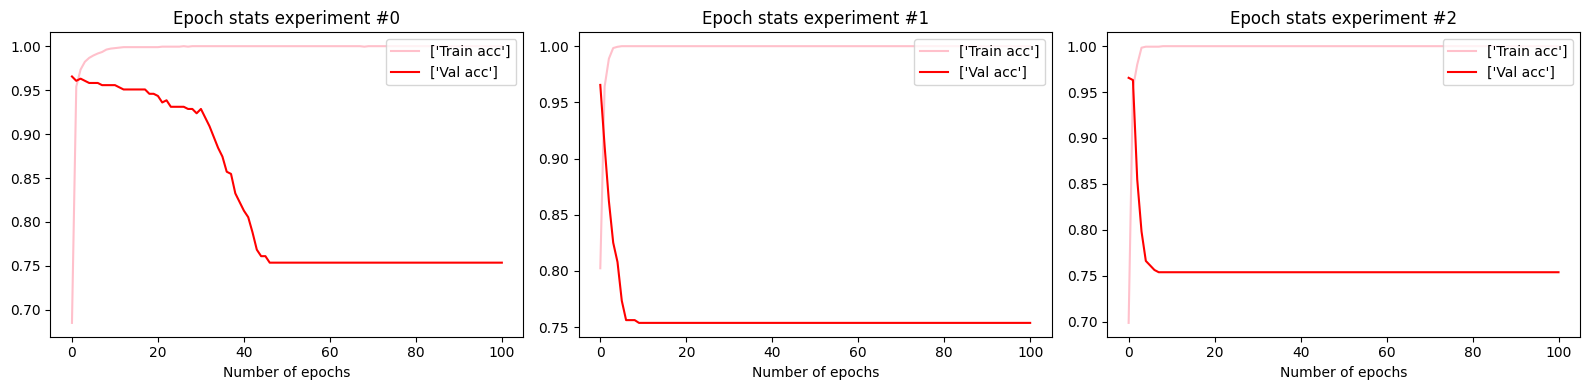

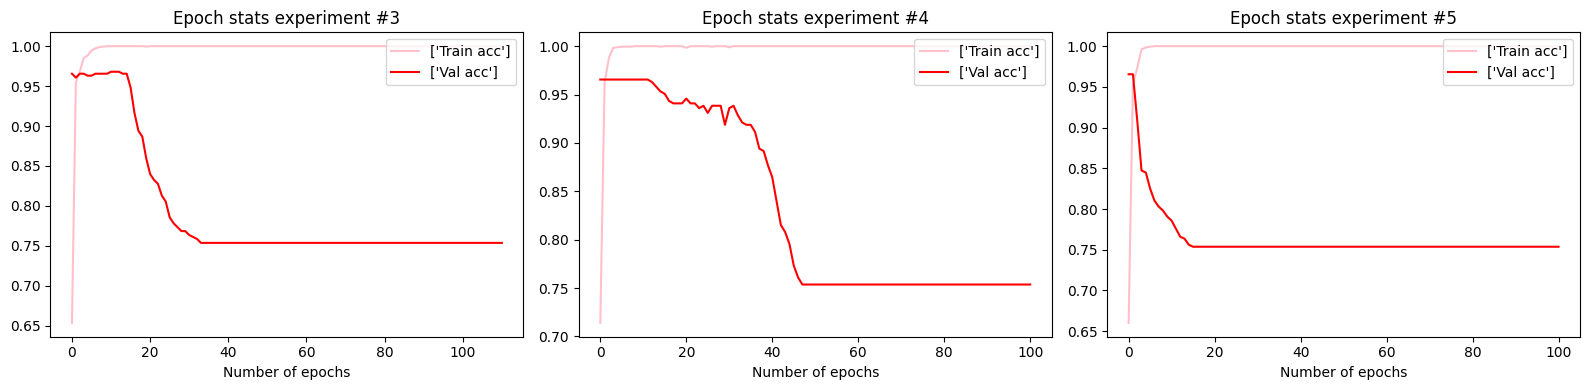

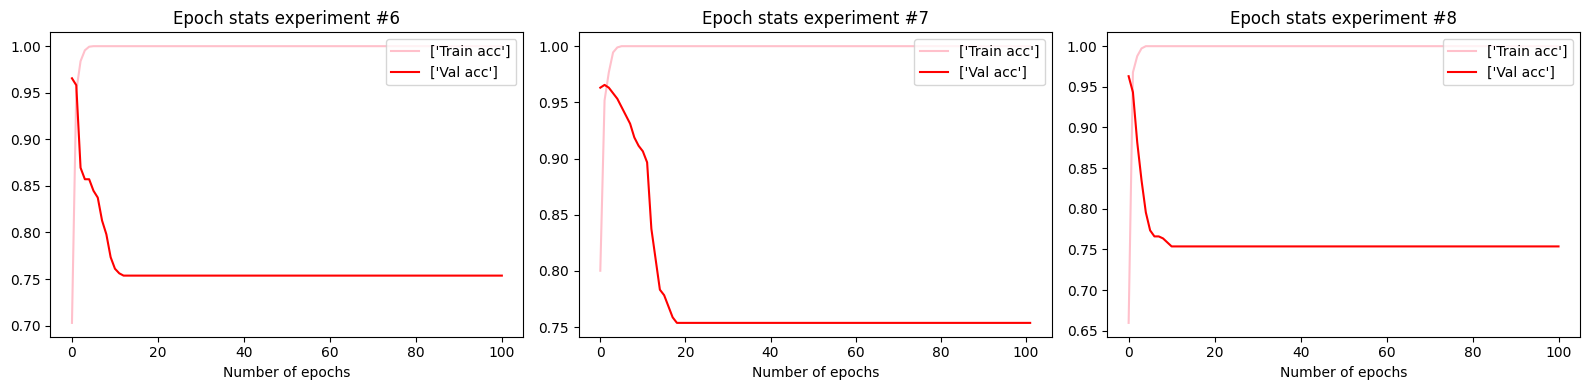

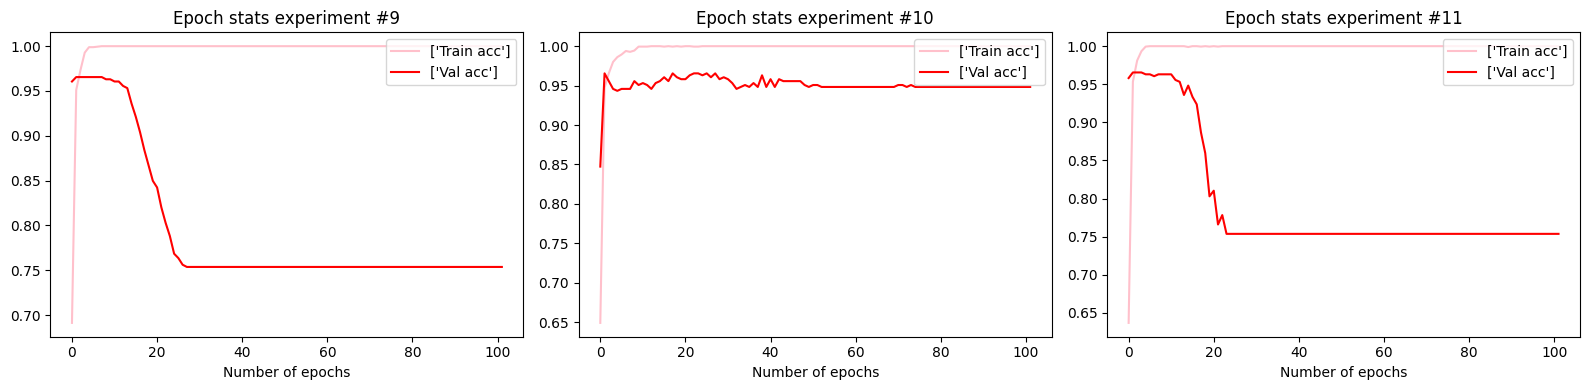

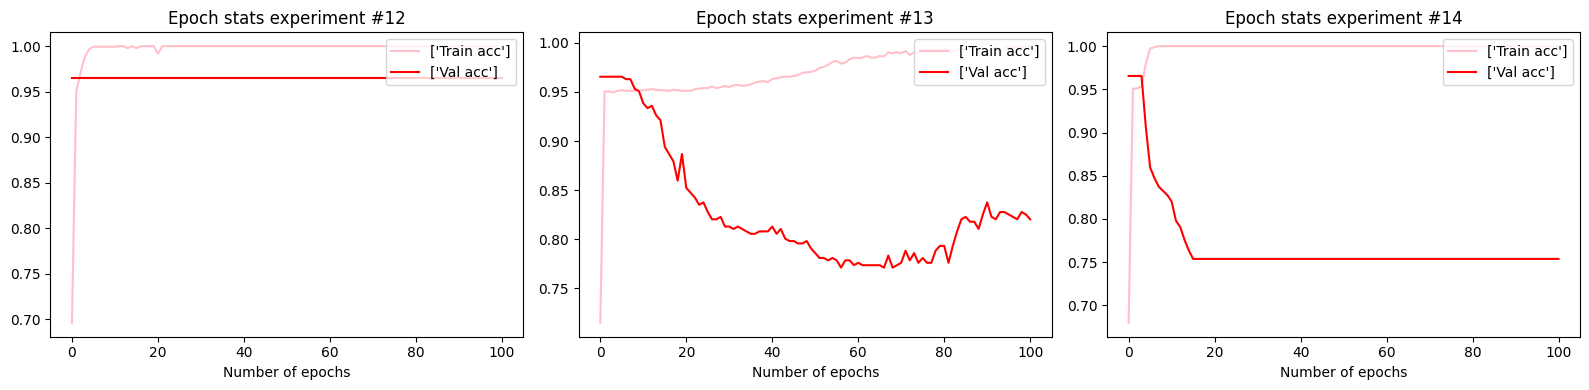

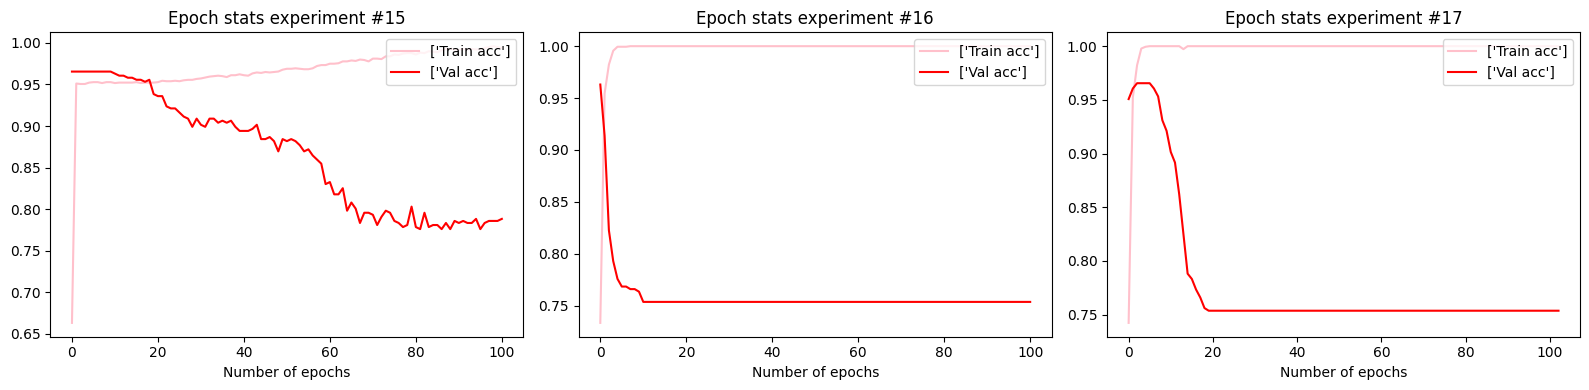

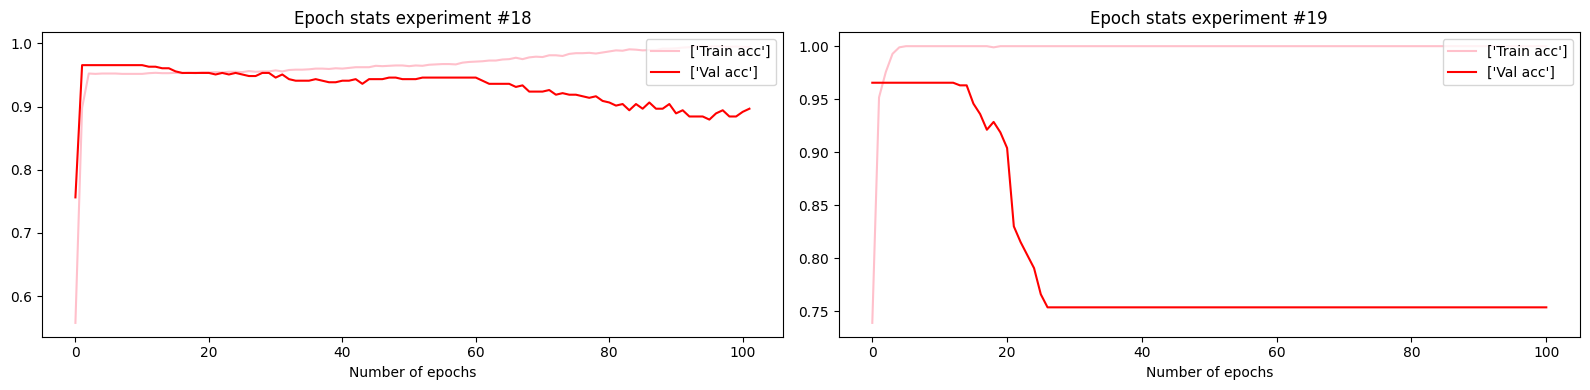

In [33]:
display_epochs_stats(cnn_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### LSTM

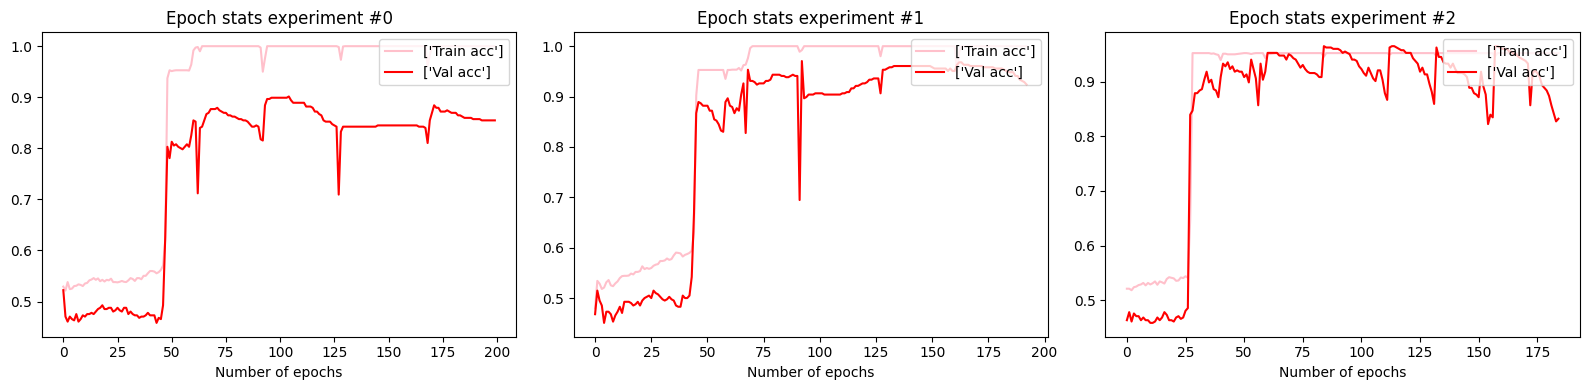

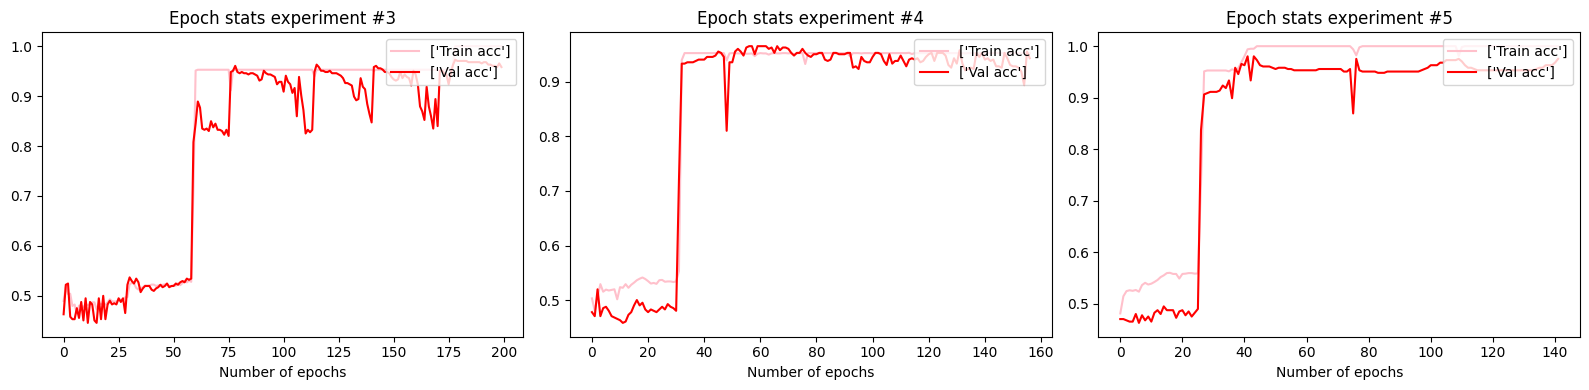

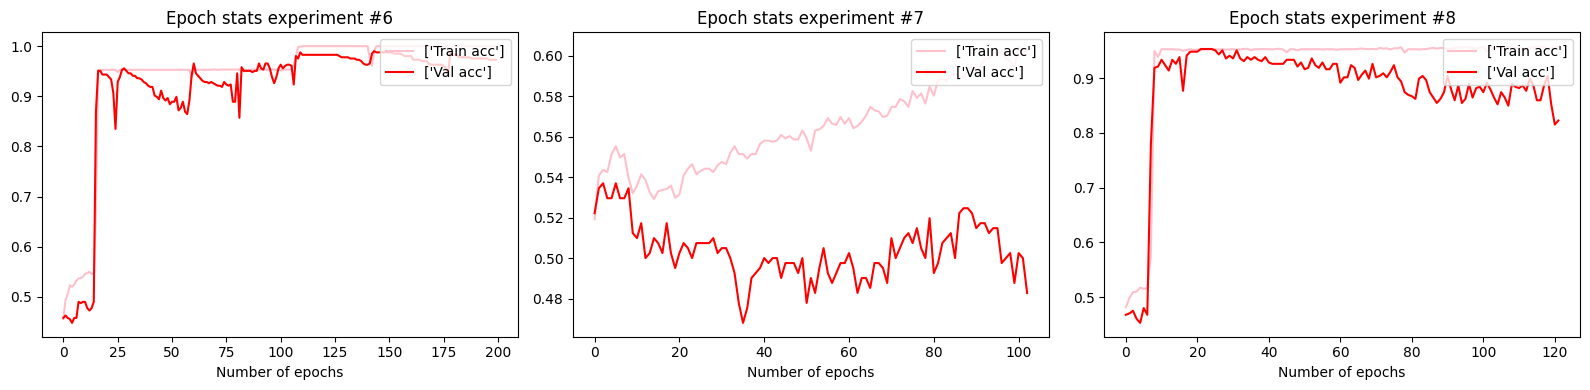

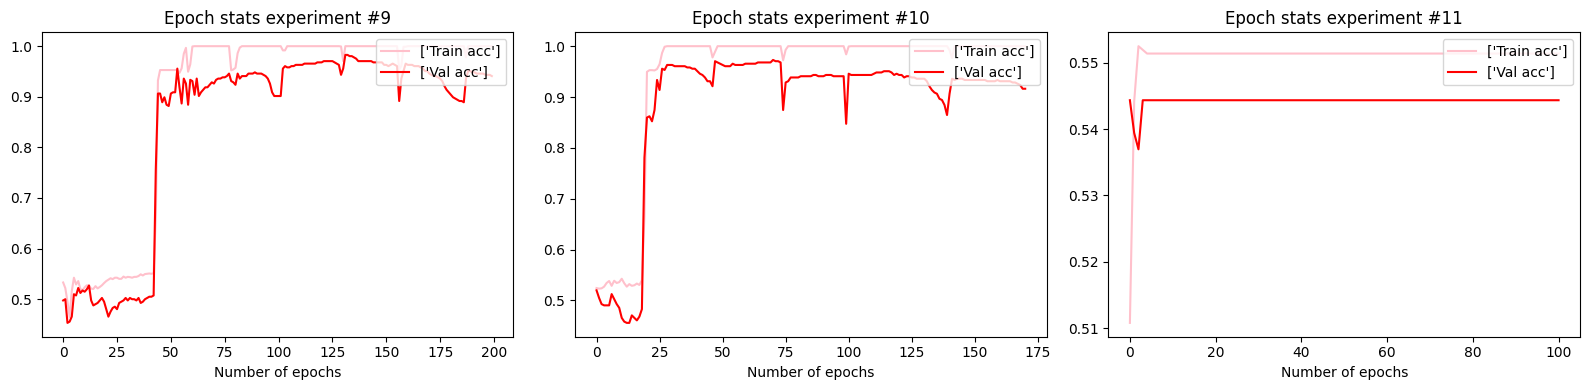

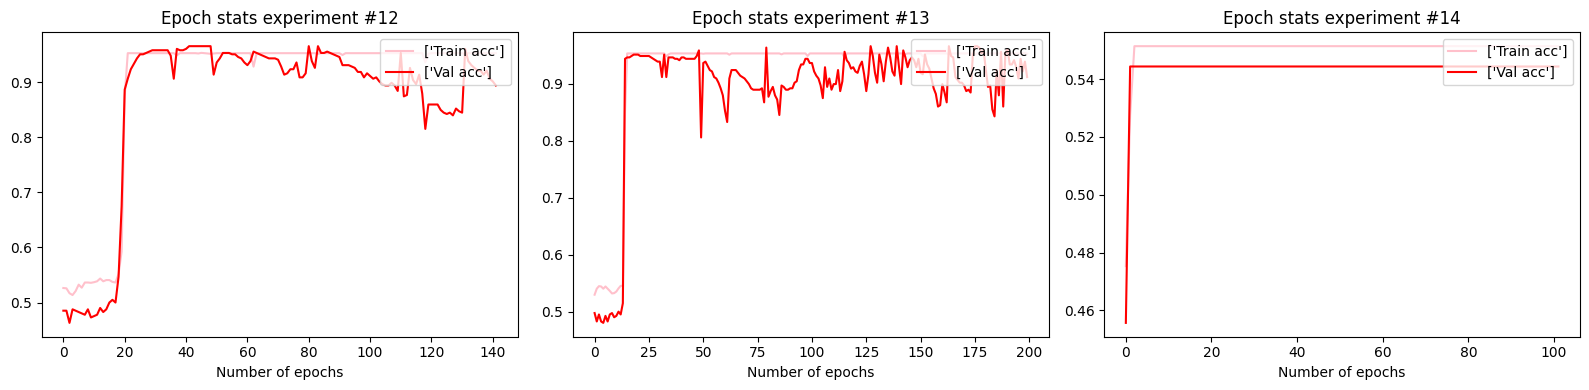

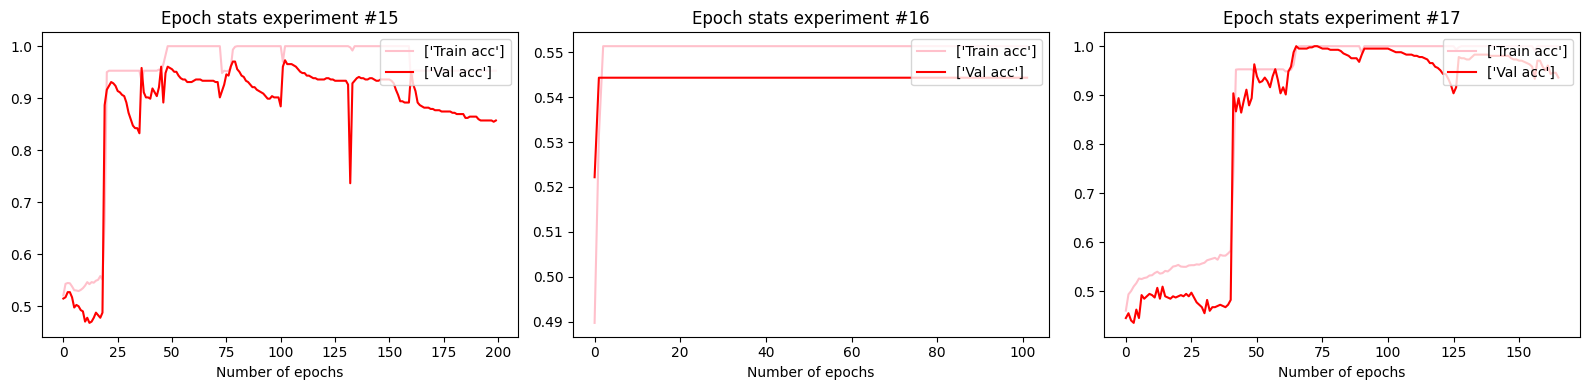

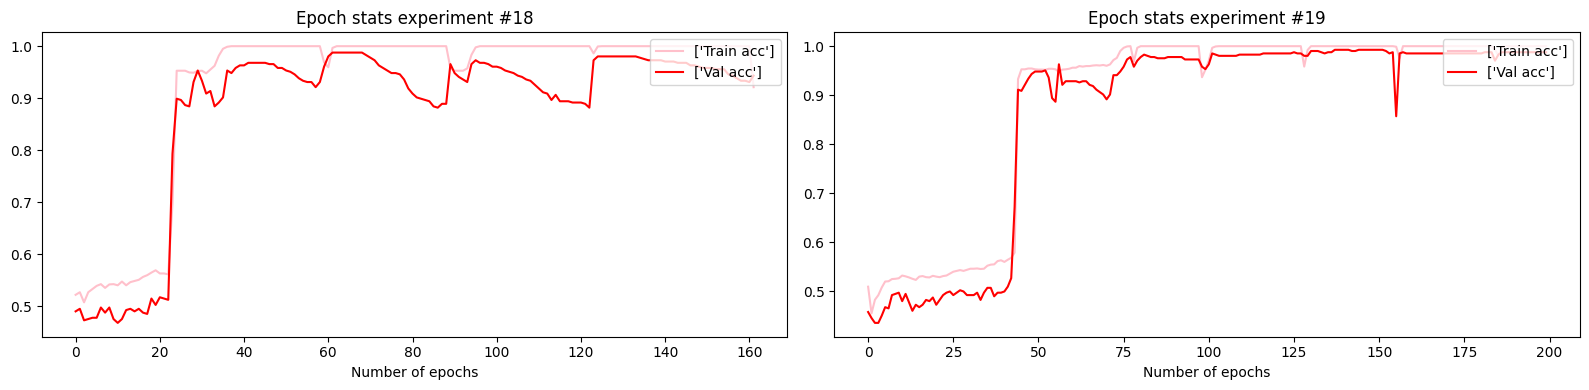

In [34]:
display_epochs_stats(lstm_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### DeepSets V1

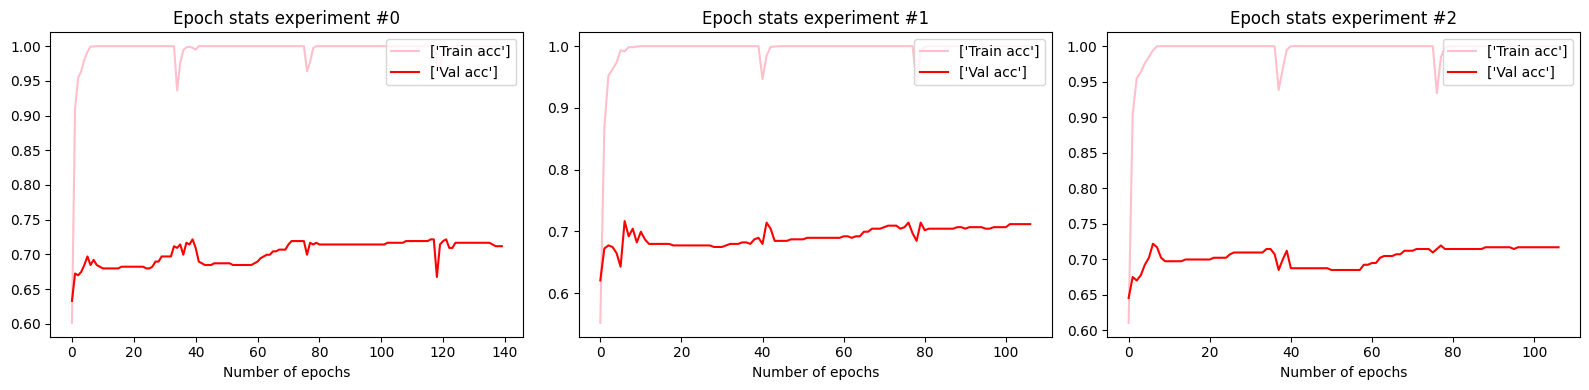

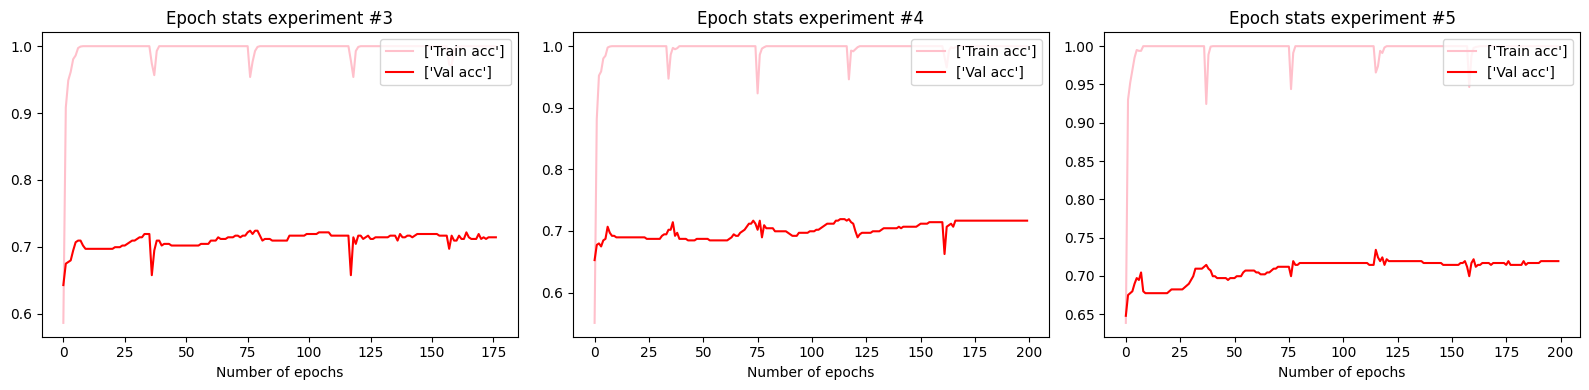

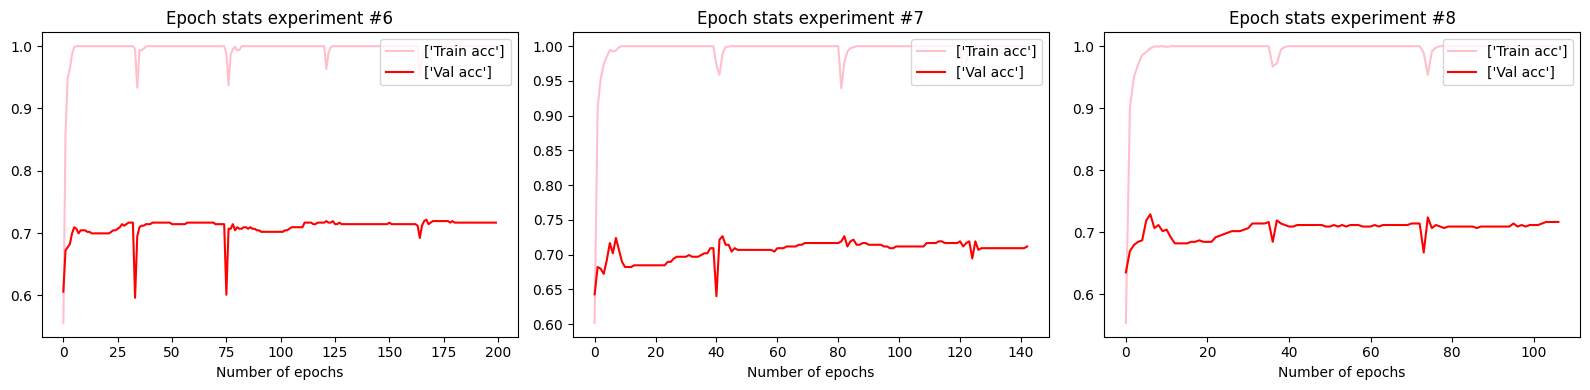

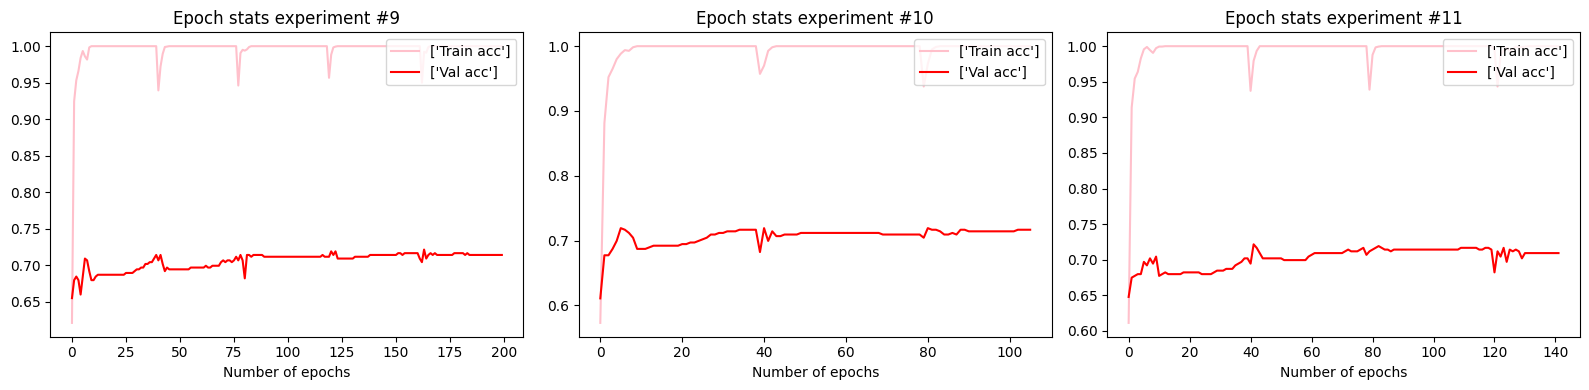

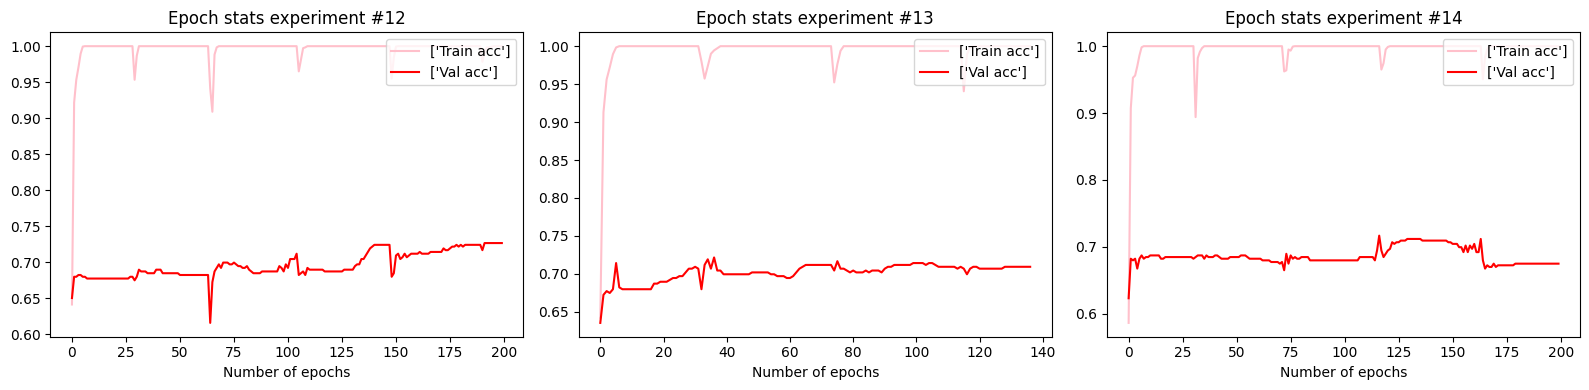

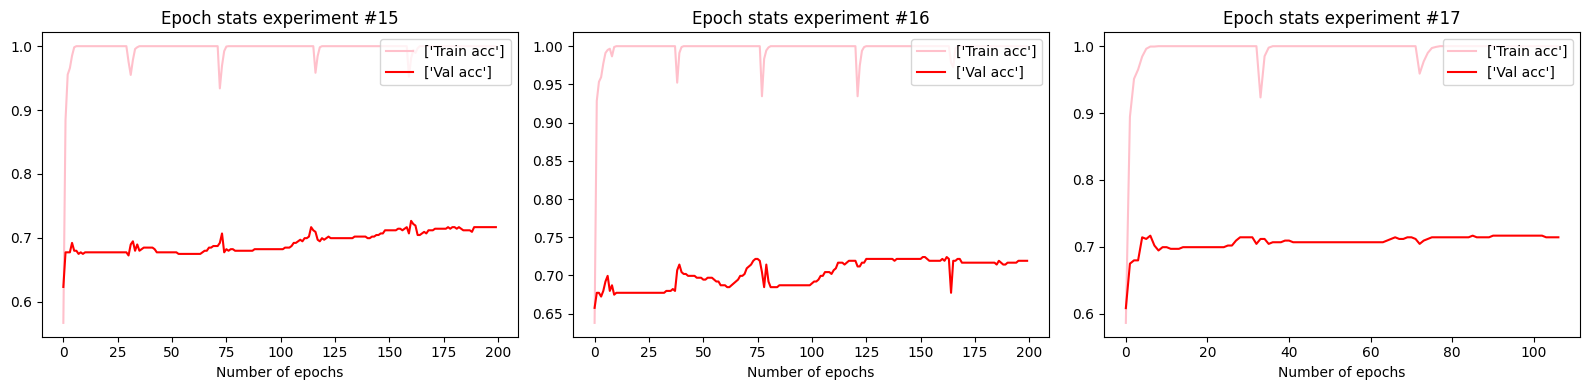

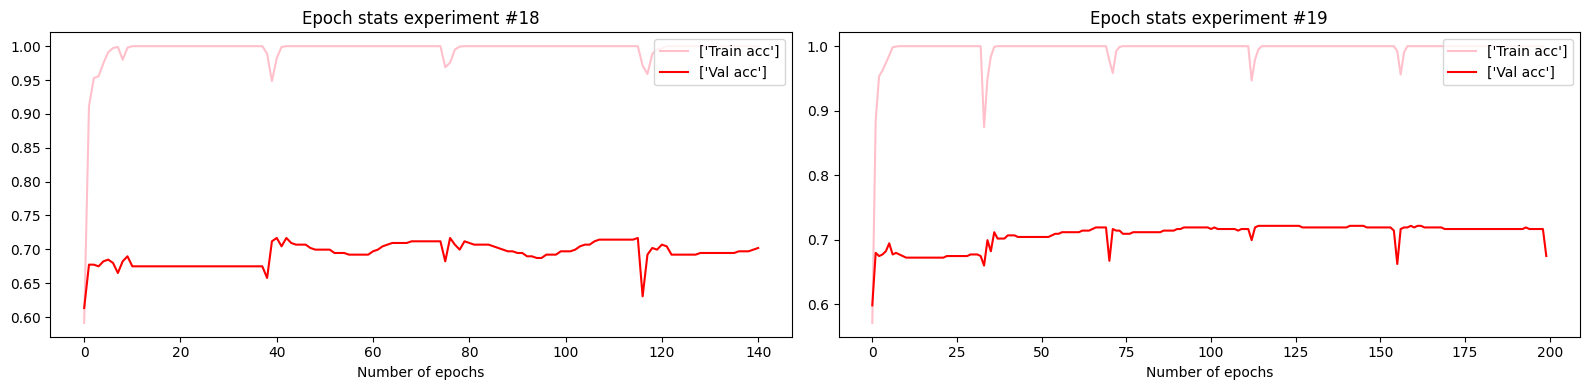

In [35]:
display_epochs_stats(deepset_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### DeepSets V2

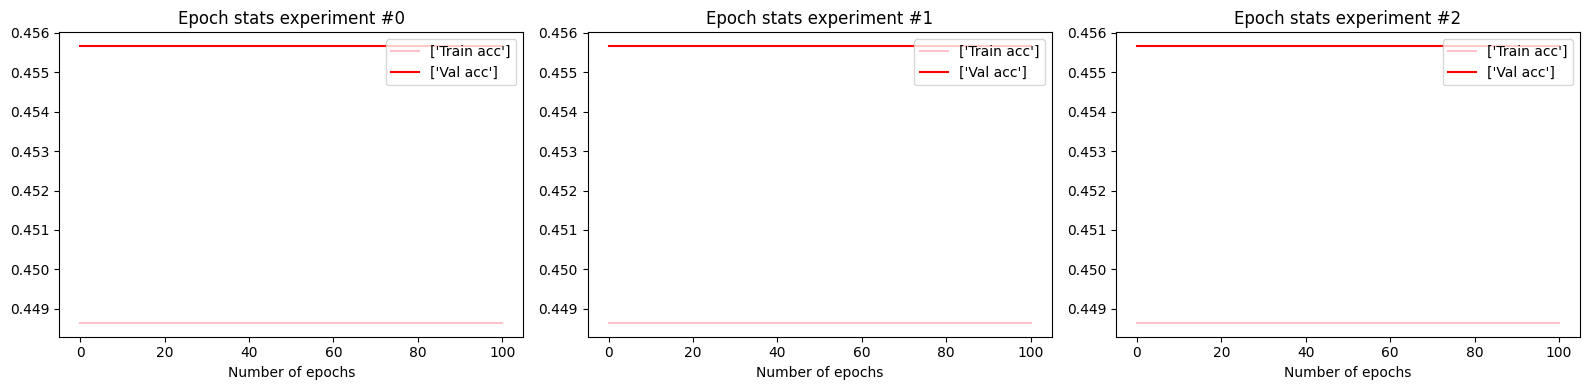

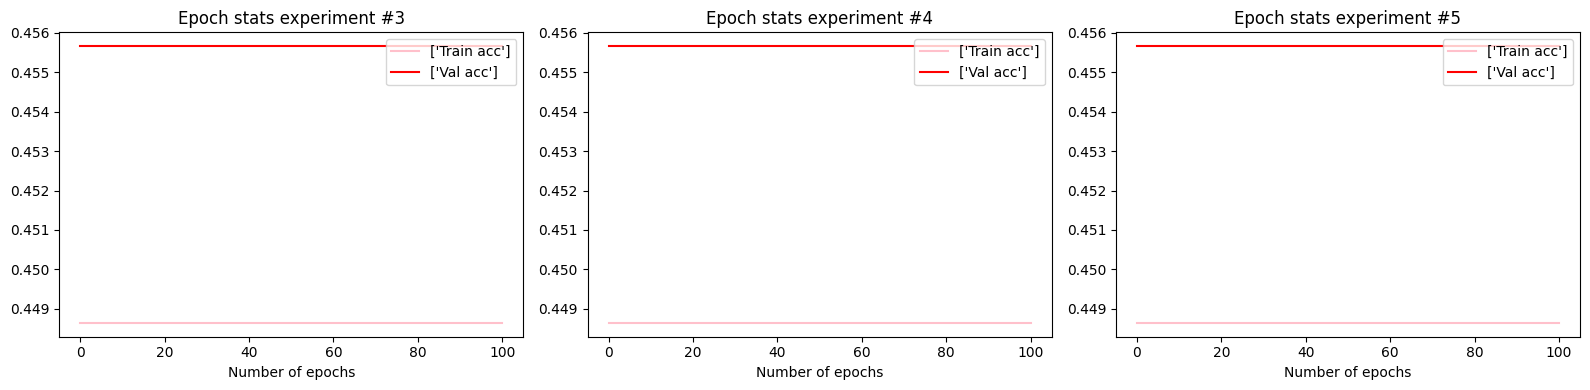

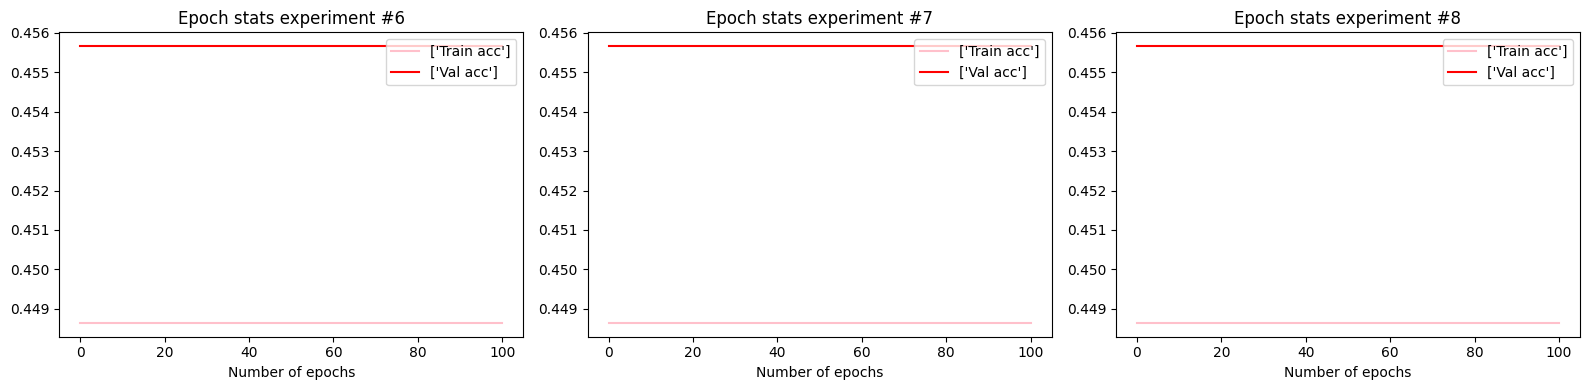

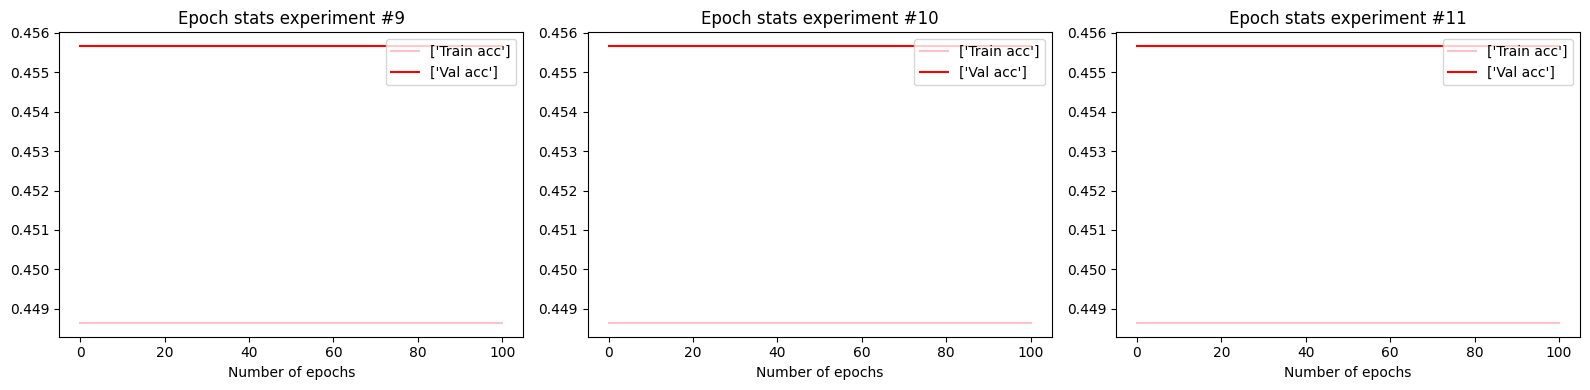

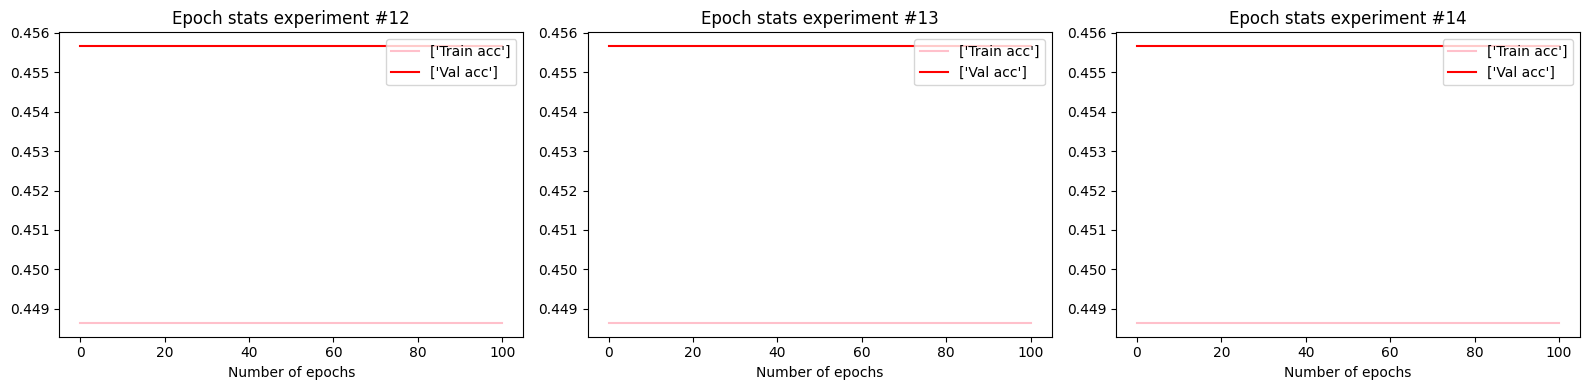

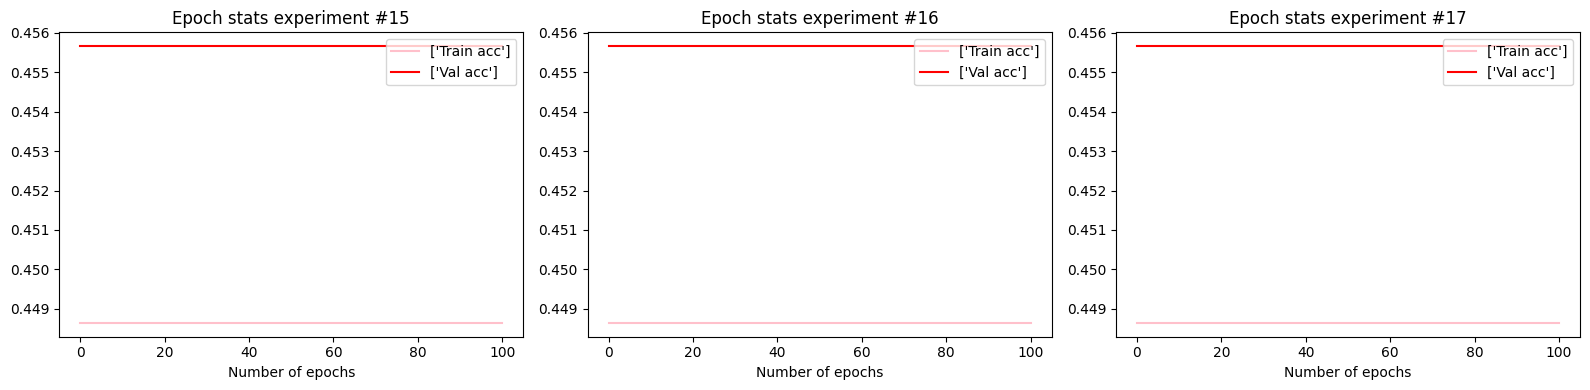

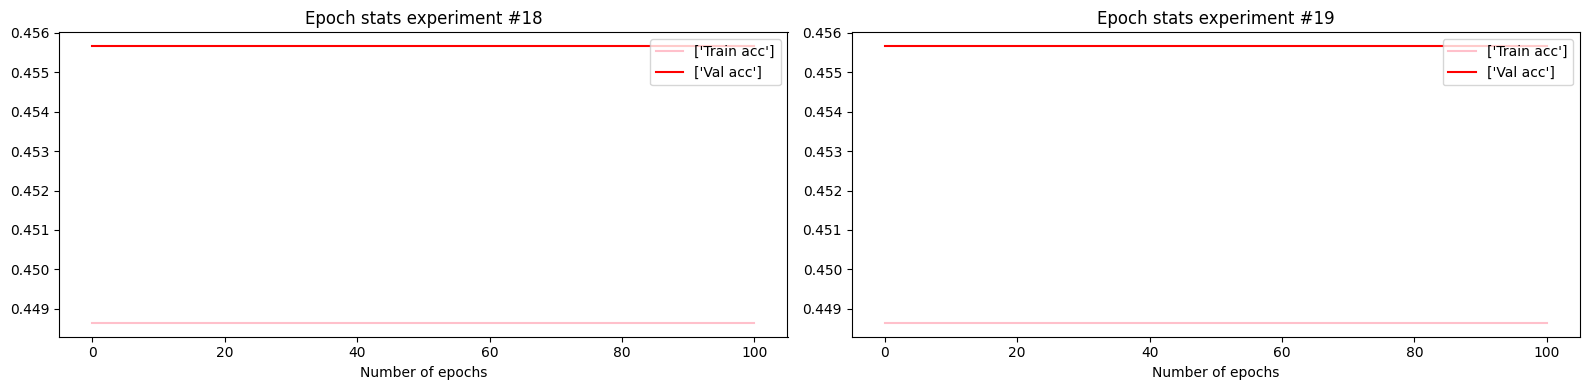

In [36]:
display_epochs_stats(deepsetv2_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### FeedForward

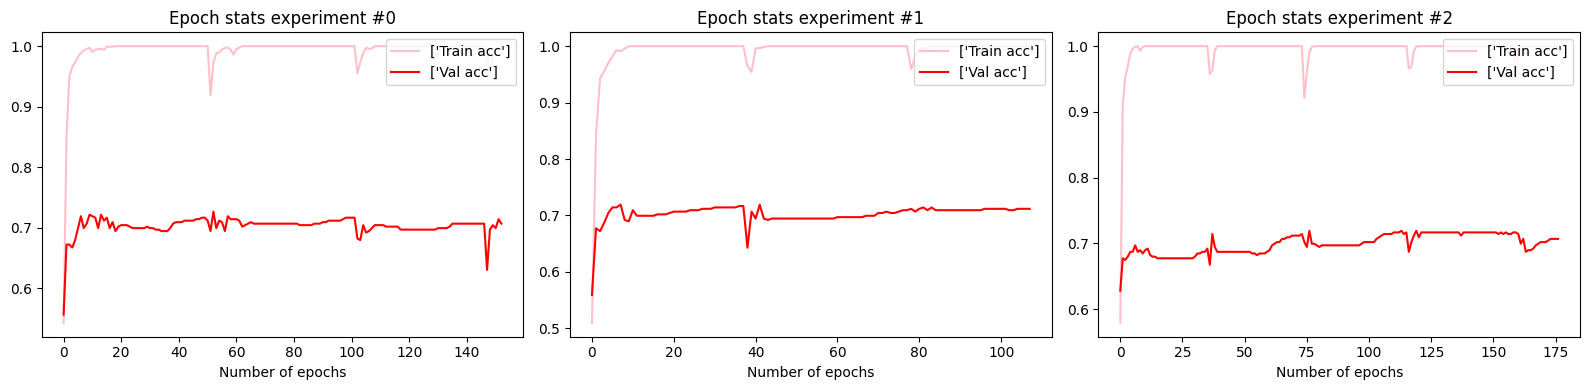

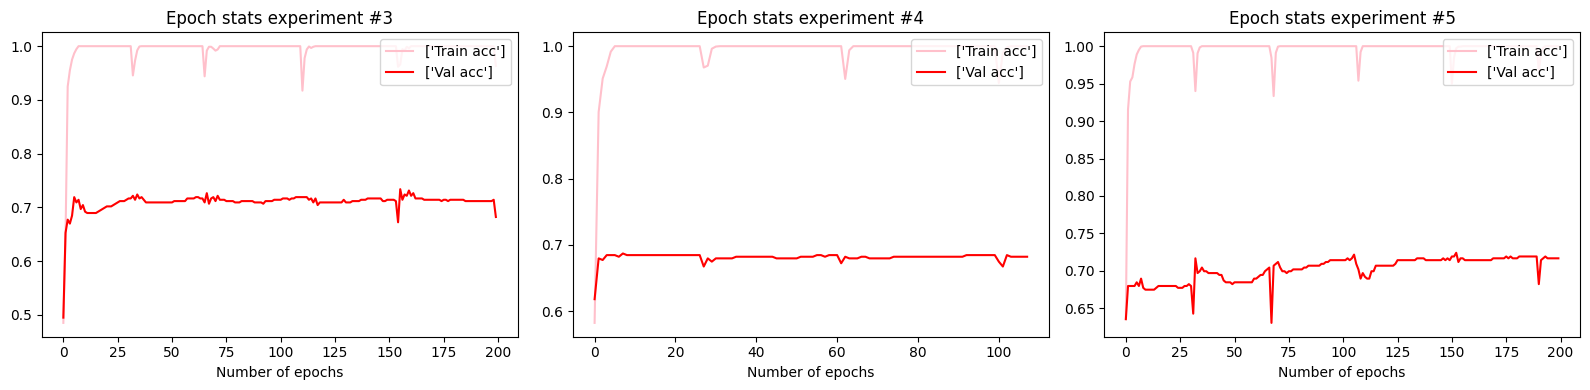

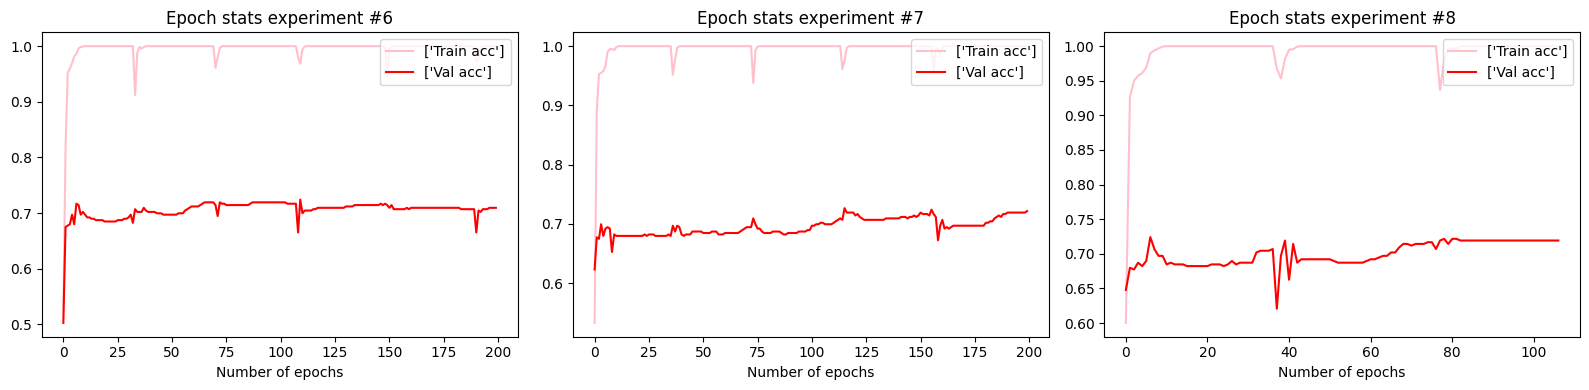

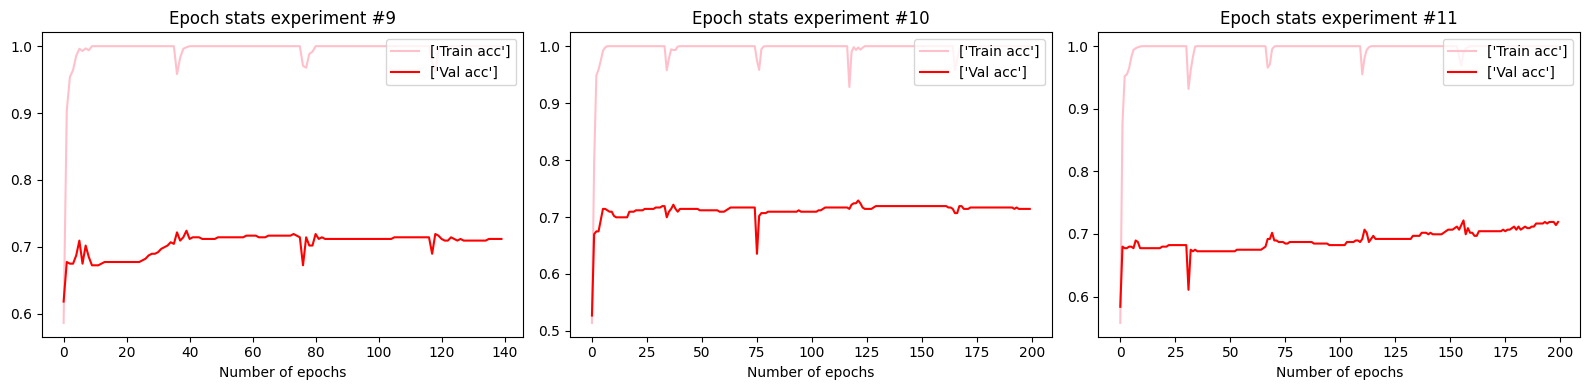

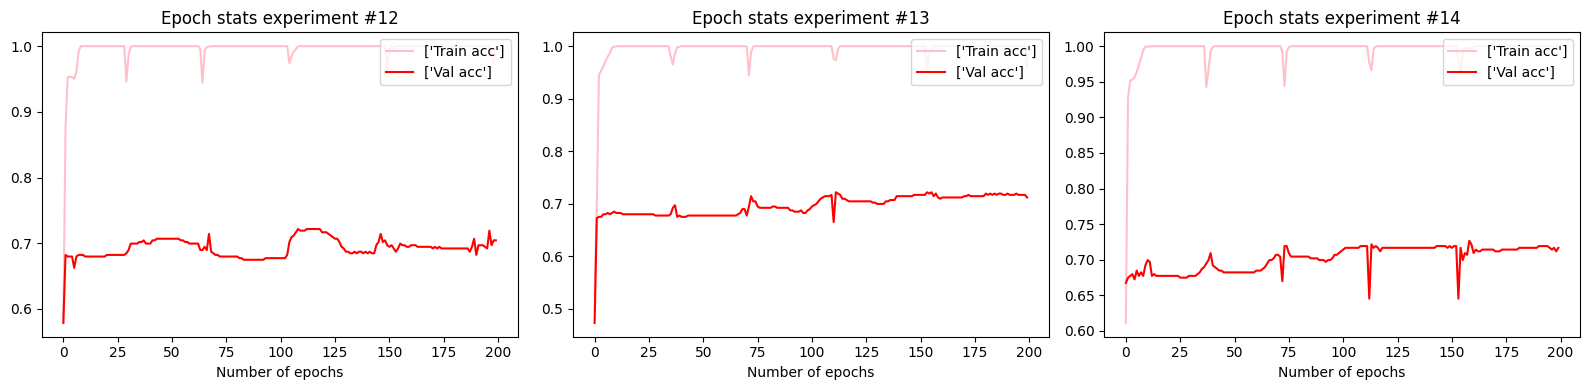

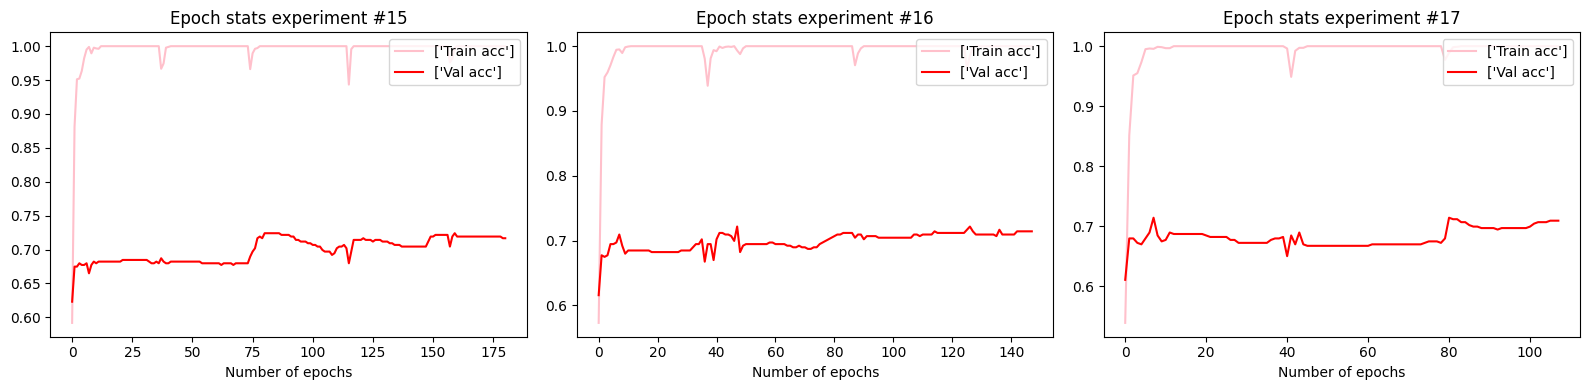

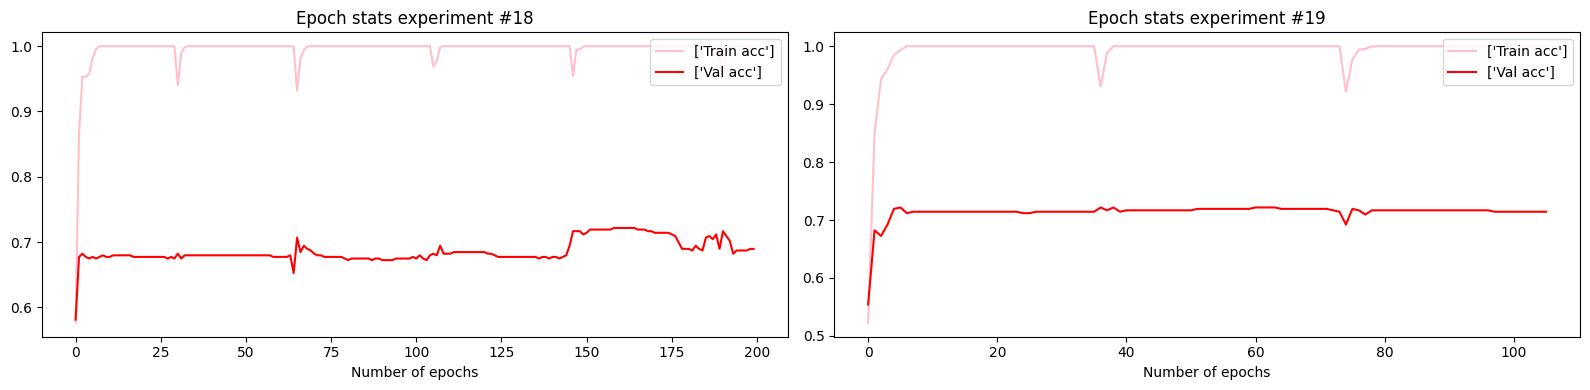

In [37]:
display_epochs_stats(feedforward_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

# Best performing models

In [38]:
best_lstm_model = LSTM_Model(data, 16, 16, 8).to(device)
best_lstm_model.load_state_dict(torch.load('./bestmodels/best_LSTM_model_' + experiment_name))
best_cnn_model = CNN_Model(data, 32, 64, 4, -1,).to(device)
best_cnn_model.load_state_dict(torch.load('./bestmodels/best_CNN_model_' + experiment_name))
best_deepset_model = DEEPSET_Model(data).to(device)
best_deepset_model.load_state_dict(torch.load('./bestmodels/best_DEEPSET_model_' + experiment_name))
best_deepsetv2_model = DEEPSETV2_Model(data).to(device)
best_deepsetv2_model.load_state_dict(torch.load('./bestmodels/best_DEEPSETV2_model_' + experiment_name))
best_feedforward_model = FEEDFORWARD_Model(data).to(device)
best_feedforward_model.load_state_dict(torch.load('./bestmodels/best_FEEDFORWARD_model_' + experiment_name))

RuntimeError: Error(s) in loading state_dict for LSTM_Model:
	size mismatch for densef1_1.weight: copying a param with shape torch.Size([32, 16]) from checkpoint, the shape in current model is torch.Size([16, 16]).
	size mismatch for densef1_1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for densef2_1.weight: copying a param with shape torch.Size([32, 16]) from checkpoint, the shape in current model is torch.Size([16, 16]).
	size mismatch for densef2_1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for densef3_1.weight: copying a param with shape torch.Size([32, 16]) from checkpoint, the shape in current model is torch.Size([16, 16]).
	size mismatch for densef3_1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for densef1_2.weight: copying a param with shape torch.Size([8, 32]) from checkpoint, the shape in current model is torch.Size([8, 16]).
	size mismatch for densef2_2.weight: copying a param with shape torch.Size([8, 32]) from checkpoint, the shape in current model is torch.Size([8, 16]).
	size mismatch for densef3_2.weight: copying a param with shape torch.Size([8, 32]) from checkpoint, the shape in current model is torch.Size([8, 16]).

## Top wrong predictions for best performing CNN model

In [ ]:
print_wrong_preds([get_wrong_predictions(best_cnn_model, x_test_cnn, y_test, test_original)], top_k=10)

Top 10 false positives: 

_,.,_,.____._.._ _,_,.,_,,c_r._._ | label: False | actual prediction: 0.7846293449401855
,,w.u..,,.,.,_._ d.r__,..___.,,._ | label: False | actual prediction: 0.7766953706741333
,.._._,__,,,_w_u _._.,_,_,__d_r__ | label: False | actual prediction: 0.753703773021698
,_.__._,,.__.,__ .__._c,r__._.,., | label: False | actual prediction: 0.7418984770774841
_,.,,_____..,.__ ,..__c,r__,_.,__ | label: False | actual prediction: 0.6969416737556458
__,_,._.,.,_,._, ,,,,,,.,_c.r_,._ | label: False | actual prediction: 0.6961515545845032
,_,,,w_u,.,,_,_. ,__d.r_,,...__,_ | label: False | actual prediction: 0.6909088492393494
_,._,,,....,,,__ ,,.,_c,r,_._.,__ | label: False | actual prediction: 0.6642907857894897
_,_,,_.,__.._w_u ,....__,_,._d.r_ | label: False | actual prediction: 0.6622198224067688
_.__w.u._..,,_,, ,,_d_r_.__._,,_, | label: False | actual prediction: 0.6448403596878052

Top 10 false negatives: 





## Top wrong predictions for best performing LSTM model

In [ ]:
print_wrong_preds([get_wrong_predictions(best_lstm_model, x_test_lstm, y_test, test_original)], top_k=10)

Top 10 false positives: 

..,_.._._.,,w_u. .,,,..,.d.r.,.,, | label: False | actual prediction: 0.7394818067550659
,._.__w.u,__._., .d_r,.____,_..., | label: False | actual prediction: 0.7366803884506226
_w,u,,,,,__,._._ ,d,r,,,__.._.,_. | label: False | actual prediction: 0.7054182291030884
.,,_,_..,_,__w,u ,,_._..d_r_,..., | label: False | actual prediction: 0.6675671339035034
_,__,_,,,_,.w,u, ...,,,_d_r,,.,_. | label: False | actual prediction: 0.6556469798088074
,,w.u..,,.,.,_._ d.r__,..___.,,._ | label: False | actual prediction: 0.634518563747406
_,_.,__,___.w,u, _.,_,,.__d.r.__. | label: False | actual prediction: 0.6336926817893982
_._..,___,.w.u,. _,,_____d_r,_.,. | label: False | actual prediction: 0.6292819380760193

Top 10 false negatives: 

.__.,___,.,u_w._ __,__,._._,,.d_r | label: True | actual prediction: 0.0018963757902383804
.___,___,,..u,w, ._.,_..,.,_.,d,r | label: True | actual prediction: 0.029343444854021072
...,_._,...._u,w ._..,,_,_.__,d,r | label: True | actua

## Top wrong predictions for best performing DeepSets V1 model

In [ ]:
print_wrong_preds([get_wrong_predictions(best_deepset_model, x_test_normal, y_test, test_original)], top_k=10)

Top 10 false positives: 

.__,_.w_u..,_,_. ,,_,d.r.,,.,.... | label: False | actual prediction: 0.9999799728393555
_,_.w.u_.,,_,.,, .,__,d.r,__,.__. | label: False | actual prediction: 0.9999661445617676
.,__w.u_.,_._,__ ..d_r.__..._,_., | label: False | actual prediction: 0.9999624490737915
___w,u_._,,,_... ,__d.r.____,_.__ | label: False | actual prediction: 0.9998810291290283
,,w.u__,,,__.,__ ,._,.d.r,_,,,.., | label: False | actual prediction: 0.9998787641525269
_w.u..,,..__,... d_r,,.._._,._,., | label: False | actual prediction: 0.9998351335525513
.,.,,_w.u_.,_.__ d.r,....,,__.,,. | label: False | actual prediction: 0.999809205532074
,,,,,,w.u..,_.,. .,d_r,,_.._,._,, | label: False | actual prediction: 0.9998016953468323
.,w.u...,.,,.,_, .._.d.r,.,..__,, | label: False | actual prediction: 0.9996275901794434
w_u.,,._,,__.._, ,_.,.d_r,_,._,._ | label: False | actual prediction: 0.9995200634002686

Top 10 false negatives: 

.__,_,.u_w._.__, .,,..,__,d.r,_.. | label: True | actual p

## Top wrong predictions for best performing DeepSets V2 model

In [ ]:
print_wrong_preds([get_wrong_predictions(best_deepsetv2_model, x_test_normal, y_test, test_original)], top_k=10)

Top 10 false positives: 


Top 10 false negatives: 

._._,,_,.,w.,,,. __,,..___.,d_r._ | label: True | actual prediction: 0.5
,u,w_..__.,_,._. ,_d_r.,_,.,,.._. | label: True | actual prediction: 0.5
,,..,,___w_u,,._ ,,_,,.,.,.r,.,_. | label: True | actual prediction: 0.5
_,._.,,,,..,w,_, ,.___..,_d,r._,. | label: True | actual prediction: 0.5
_..,,,_.,.u,w_._ ___,___,,_,.r.._ | label: True | actual prediction: 0.5
___,....,..____, ...__._,_,.._r.. | label: True | actual prediction: 0.5
,,,____,,_w_u,_. .__.,,.._._..,r_ | label: True | actual prediction: 0.5
,.,..,.,w,u,,_,, .....,,,,,.._r_, | label: True | actual prediction: 0.5
.__,.._._w..,_.. _.___,,._r.,,... | label: True | actual prediction: 0.5
.,._.,.,,__.,_,. .,_.,....,,,_r_. | label: True | actual prediction: 0.5




## Top wrong predictions for best performing Feedforward model

In [ ]:
print_wrong_preds([get_wrong_predictions(best_feedforward_model, x_test_normal, y_test, test_original)], top_k=10)

Top 10 false positives: 

.__,_.w_u..,_,_. ,,_,d.r.,,.,.... | label: False | actual prediction: 0.9984936714172363
,___.,w,u,,,.,,. ,_,.,.d.r.,__,,, | label: False | actual prediction: 0.9977770447731018
.,__w.u_.,_._,__ ..d_r.__..._,_., | label: False | actual prediction: 0.9951000809669495
___w,u_._,,,_... ,__d.r.____,_.__ | label: False | actual prediction: 0.9893458485603333
__,.w.u,_,.,..,_ ..__d.r.___,.._, | label: False | actual prediction: 0.9783236980438232
_w,u_..,_,,,_._. .,.d_r_,_____,,. | label: False | actual prediction: 0.9779928922653198
w.u,,_,.__,_.,._ ,,,_,.d_r._...,, | label: False | actual prediction: 0.975769579410553
w_u__,.._,..,... ._d,r.,._._,_,,_ | label: False | actual prediction: 0.9755761027336121
.,.,,_w.u_.,_.__ d.r,....,,__.,,. | label: False | actual prediction: 0.9729065895080566
_.w,u,,__,_.__.. ,,.d_r,_._,.__,. | label: False | actual prediction: 0.97234046459198

Top 10 false negatives: 

__,_...u.w.,,_,_ ,,_.,.._.,__,r_. | label: True | actual pre

# Saving Notebook State

In [ ]:
import dill
dill.dump_session('notebook_env_' + experiment_name + '.db')

ModuleNotFoundError: No module named 'dill'

# Loading Notebook State

In [ ]:
import dill
experiment_name = "f2_f4_easy_redo"
# dill.load_session('notebook_env_' + experiment_name + '.db')